In [67]:
import pickle
from math import floor
import scipy.stats
from pylab import * 
import numpy as np
import seaborn as sns
%matplotlib inline
%run "/home/ibis/gregor.sturm/nanopore/own/notebooks/03_pipeline/analysis_lib.ipynb"

In [12]:
args = {
    "true_events": "/home/ibis/gregor.sturm/nanopore/own/notebooks/03_pipeline/david_alignment_true_events.pickle",
    "ref": "/home/ibis/gregor.sturm/nanopore/david_eccles_bc_ideas/mouse_ref.fa",
}

# args = {
#     "true_events": "/home/ibis/gregor.sturm/nanopore/own/notebooks/03_pipeline/lambda_alignment_true_events.pickle",
#     "ref": "/home/ibis/gregor.sturm/nanopore/own/notebooks/03_pipeline/lambda_ref.fasta",
# }

In [13]:
NMER = 3

In [14]:
!pwd

/home/ibis/gregor.sturm/nanopore/own/notebooks/04_error_correction


In [15]:
true_events = pickle.load(open(args["true_events"], 'rb'))

In [16]:
ref_file = args["ref"]
test = !cat {ref_file} | grep ">"
print(test)
ref = !cat {ref_file} | grep -v ">"
ref = ref[0]
print(ref[:100])

['>mmusMT_PCR1']
GTTAATGTAGCTTAATAACAAAGCAAAGCACTGAAAATGCTTAGATGGATAATTGTATCCCATAAACACAAAGGTTTGGTCCTGGCCTTATAATTAATTA


In [48]:
def get_context(event, start, end):
    """get the nt-context around the kmer. 
    E.g. start=-20: get context 20nt before the reference point
    (mid of kmer)"""
    ref_pos = event["ref_position"]
    start = ref_pos + start
    end = ref_pos + end
    return ref[start:end]

def get_context_before(event, n):
    """get n nucleotides before the start of the kmer"""
    length = len(event["kmer"])
    offset = int(-floor(length/2))
    return get_context(event, -n+offset, offset)
    
def get_context_after(event, n):
    length = len(event["kmer"])
    offset = int(floor(length/2) + 1)
    return get_context(event, offset, offset+n)

In [49]:
test_event = true_events[0]
assert test_event['kmer'] == get_context(test_event, -2, 2+1), "invalid reference"
assert (get_context_before(test_event, 20) 
        + test_event['kmer'] 
        + get_context_after(test_event, 20)) == (
    get_context(test_event, -22, 22+1))

## Analysis 

In [27]:
all_5mers = mk_kmer_dict(NMER)
ev_map = mk_event_map(true_events, all_5mers)

In [68]:
template_events = [ev for ev in ev_map["ATG"] if not np.isnan(ev["template.mean"])]
means = [ev["template.mean"] for ev in template_events]
stdvs = [ev["template.stdv"] for ev in template_events]
context_before = [get_context_before(ev, 30) for ev in template_events]
context_after = [get_context_after(ev, 30) for ev in template_events]
nt_before = [NT_MAP[x[-1]] for x in context_before]
nt_after = [NT_MAP[x[0]] for x in context_after]


(array([  0.,   1.,   0.,   1.,   2.,   3.,   5.,   5.,   6.,   9.,  14.,
         17.,  25.,  22.,  21.,  29.,  37.,  31.,  31.,  34.,  33.,  24.,
         30.,  42.,  30.,  41.,  23.,   9.,  14.,  10.,  12.,   5.,   1.,
          0.,   1.,   0.,   1.,   0.,   0.]),
 array([ 50. ,  50.5,  51. ,  51.5,  52. ,  52.5,  53. ,  53.5,  54. ,
         54.5,  55. ,  55.5,  56. ,  56.5,  57. ,  57.5,  58. ,  58.5,
         59. ,  59.5,  60. ,  60.5,  61. ,  61.5,  62. ,  62.5,  63. ,
         63.5,  64. ,  64.5,  65. ,  65.5,  66. ,  66.5,  67. ,  67.5,
         68. ,  68.5,  69. ,  69.5]),
 <a list of 39 Patch objects>)

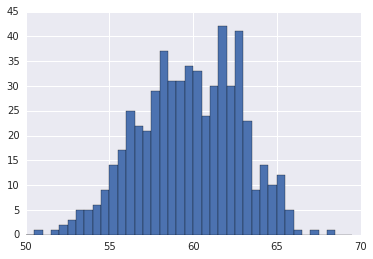

In [53]:
hist(means, bins=np.arange(50, 70, .5))

(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    1.,    3.,
          17.,   64.,  105.,  122.,   91.,   47.,   36.,   24.,   21.,
          10.,    8.,    8.,    3.,    2.,    1.,    1.,    1.,    0.,
           1.,    0.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
         1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
         2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9]),
 <a list of 29 Patch objects>)

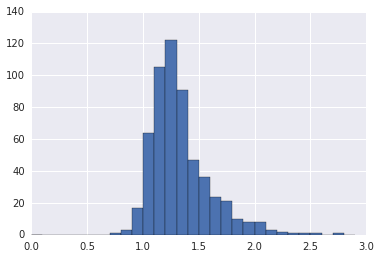

In [39]:
hist(stdvs, bins=np.arange(0, 3, .1))

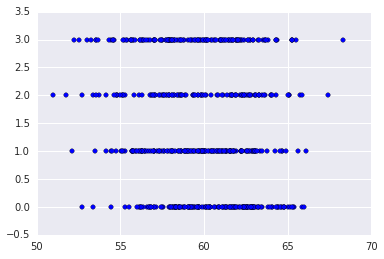

In [69]:
fig, ax = subplots()
ax.scatter(means, nt_before)

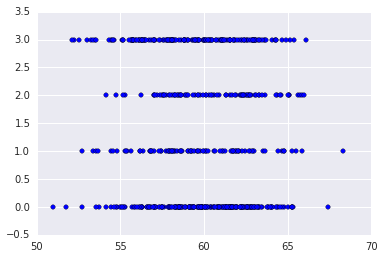

In [70]:
fig, ax = subplots()
ax.scatter(means, nt_after)